In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from utils.networks import DecoderNN_1input
from utils.transforms import *
from utils.datasets import plot_images_stacked, get_cifar10_raw_dataloader

import numpy as np



import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/nazim/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


'cuda'

In [2]:
loader = get_cifar10_raw_dataloader(10, 512)

In [4]:
for i, (x, y) in enumerate(loader):
    print(i, len(x), y.shape)

0 512 torch.Size([512])
1 512 torch.Size([512])
2 512 torch.Size([512])
3 512 torch.Size([512])
4 512 torch.Size([512])
5 512 torch.Size([512])
6 512 torch.Size([512])
7 512 torch.Size([512])
8 512 torch.Size([512])
9 512 torch.Size([512])


In [9]:
import pickle

with open('policy.pkl', 'rb') as file:
    policy = pickle.load(file)
    all_policies = [policy]*30

In [3]:
cifar10_dataset = torchvision.datasets.CIFAR10('dataset', download=True)

Files already downloaded and verified


In [16]:
subpolicy_1, subpolicy_2 = random.choice(policy)
subpolicy_1

[('Solarize', 0.8, 0.6666666865348816), ('TranslateY', 0.8, 1.0)]

In [271]:
class Augmentation(object):
    def __init__(self, policies, dist):
        
        assert len(policies) != 0, 'policies should contain at least one policy'
        assert np.isclose(sum(dist), 1), 'probabilities do not sum to 1'
        assert len(policies) >= len(dist), 'len(policies) must be greater than len(dist)'
        
        self.policies = policies
        self.dist = dist
        
        
    
    def get_policy(self, dist):
        idx = np.random.choice(range(len(dist)), p=dist)
        policy = self.policies[-(idx+1)]
        return policy
    
    def __call__(self, img, branch=None):
        
        policy = self.get_policy(self.dist)
        
        img = img.copy()
        subpolicy_1, subpolicy_2 = random.choice(policy)

        if branch == 1:
            subpolicy_1, _ = random.choice(policy)
            img = img.copy()
            for name, pr, lvl in subpolicy_1:
                if random.random() < pr:
                    img = apply_augment(img, name, lvl)
            return img
        
        
        elif branch == 2:
            _, subpolicy_2 = random.choice(policy)
            img = img.copy()
            for name, pr, lvl in subpolicy_2:
                if random.random() < pr:
                    img = apply_augment(img, name, lvl)
            return img
        
        
        elif branch is None:
            subpolicy_1, subpolicy_2 = random.choice(policy)
            img1, img2 = img.copy(), img.copy()
            
            for name, pr, lvl in subpolicy_1:
                if random.random() < pr:
                    print(name)
                    img1 = apply_augment(img1, name, lvl)
            
            for name, pr, lvl in subpolicy_2:
                if random.random() < pr:
                    print(name)
                    img2 = apply_augment(img2, name, lvl)
            
            return img1, img2

In [272]:
class MyDatset(Dataset):
    def __init__(self, train_dataset, policies, random_p, ppo_dist):
        self.train_dataset = train_dataset
        self.policies = policies
        self.random_p = random_p
        
        self.random_policy = RandomAugmentation(N=2, pr=0.8)
        self.ppo_policy = Augmentation(policies, dist=ppo_dist)
        
        self.last_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
        ])


    def __len__(self,):
        return len(self.train_dataset)
    
    def __getitem__(self, i):
        img, y = self.train_dataset[i][0], self.train_dataset[i][1]
        img1, img2 = img.copy(), img.copy()
        
        img1_is_random = random.random() < self.random_p
        img2_is_random = random.random() < self.random_p
        
        if img1_is_random and img2_is_random:
            img1 = self.random_policy(img1)
            img2 = self.random_policy(img2)
        
        elif not img1_is_random and img2_is_random:
            img1 = self.ppo_policy(img1, branch=1)
            img2 = self.random_policy(img2)
        
        elif img1_is_random and not img2_is_random:
            img1 = self.random_policy(img1)
            img2 = self.ppo_policy(img2, branch=2)
        
        elif not img1_is_random and not img2_is_random:
            img1, img2 = self.ppo_policy(img) 
        
        img = self.last_transform(img)
        img1 = self.last_transform(img1)
        img2 = self.last_transform(img2)
        y = torch.tensor(y, dtype=torch.long).unsqueeze(0)
        
        return img, img1, img2, y

In [273]:
all_policies[-1] = [[
    [('Invert', 1, 0.6666666865348816)],
    [('Invert', 1, 0.1111111119389534)]
]]

all_policies[-2] = [[
    [('Brightness', 1, 0)],
    [('Brightness', 1, 0)]
]]

In [290]:
dataset = MyDatset(cifar10_dataset, all_policies[:3], random_p=0, ppo_dist=[0.25, 0.25, 0.25, 0.25])
data_loader = DataLoader(dataset, batch_size=10, drop_last=True, shuffle=True)

AssertionError: len(policies) must be greater than len(dist)

-3
Equalize
Contrast
Sharpness
-1
Invert
Invert
-1
Invert
Invert
-2
Brightness
Brightness
-3
AutoContrast
Brightness
Cutout
-3
TranslateX
AutoContrast
Sharpness
AutoContrast
-3
Color
Sharpness
Contrast
ShearY
-3
Color
Contrast
AutoContrast
-1
Invert
Invert
-3
TranslateX
Sharpness
Rotate


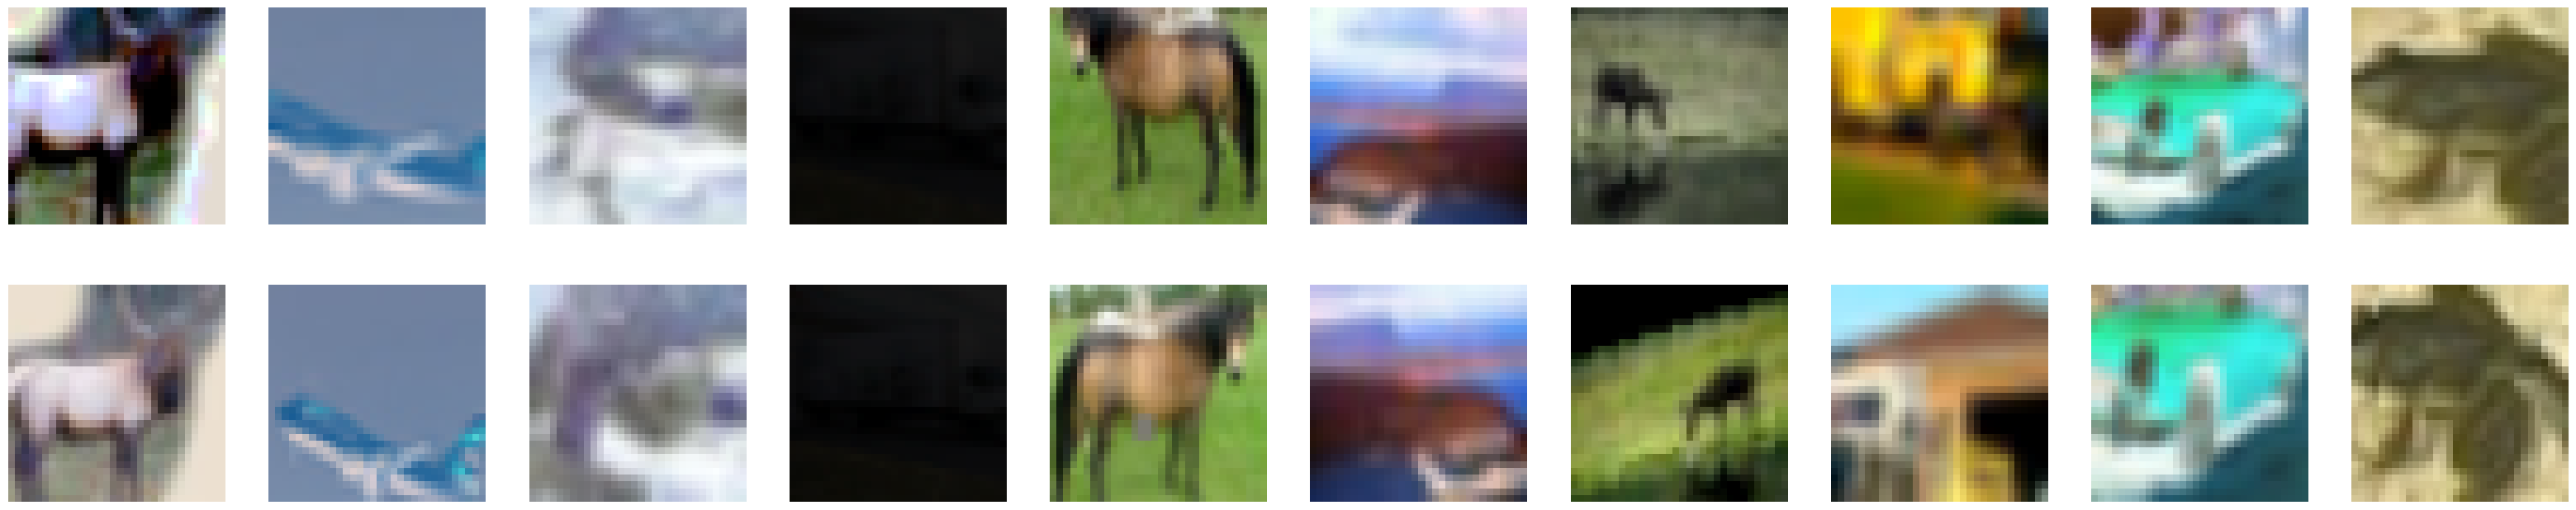

In [289]:
img, img1, img2, y = next(iter(data_loader))
plot_images_stacked(img1[:10], img2[:10])

In [161]:
dist = [0.955, 0.05, 0.05]
idx = np.random.choice(range(3), p=dist)
# policy = 

ValueError: probabilities do not sum to 1

In [9]:
def get_policy_distribution(N, p):
    return [p*(1-p)**n/(1-(1-p)**N) for n in range(N)]
    

In [32]:
97*512 * 0.0009

44.6976

In [50]:
for i in range(1, 5):
    print(i, get_policy_distribution(i, 0.7))

1 [1.0]
2 [0.7692307692307693, 0.2307692307692308]
3 [0.7194244604316546, 0.21582733812949642, 0.06474820143884893]
4 [0.7057163020465772, 0.2117148906139732, 0.06351446718419197, 0.019054340155257594]
